## MACD with Python

Default setting s for MACD indicator in tradingview.com are Fast length = 12
Slow length = 26
Signal smoothing = 9

Buy sell signals are generated when MACD line crosses the signal line.

In addition to this we have also the histogram that servers as an early warning for crossovers. When bars are getting shorter, it signals that crossover signal might come soon.

Bullish market -  when both lines are above zero, crossover is sell signal
Bearish market - when both lines are below zero, crossover is buy signal

And the crossover might signify the reversal of a trend.


In [133]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [134]:
# ___variables___
ticker = 'AAPL'
#ticker = 'TSLA'
#ticker = 'GOOGL'

start_time = datetime.datetime(2019, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [135]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date       High        Low       Open      Close       Volume  Adj Close
0 2019-01-02  39.712502  38.557499  38.722500  39.480000  148158800.0  38.629097
1 2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0  34.781353
2 2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0  36.266144
3 2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0  36.185429
4 2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0  36.875229


In [136]:
df = ticker_df

In [137]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Adj Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [138]:
df = computeMACD(df, 12, 26, 9)

In [139]:
print(df.head())
print(df.tail())

        Date       High        Low       Open      Close       Volume  Adj Close  MACD  MACDsig  MACDhist
0 2019-01-02  39.712502  38.557499  38.722500  39.480000  148158800.0  38.629097   NaN      NaN       NaN
1 2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0  34.781353   NaN      NaN       NaN
2 2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0  36.266144   NaN      NaN       NaN
3 2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0  36.185429   NaN      NaN       NaN
4 2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0  36.875229   NaN      NaN       NaN
          Date        High         Low        Open       Close       Volume   Adj Close      MACD   MACDsig  MACDhist
445 2020-10-07  115.550003  114.129997  114.620003  115.080002   96849000.0  115.080002 -0.055348 -0.318113  0.262765
446 2020-10-08  116.400002  114.589996  116.250000  114.970001   83477200.0  114.970001  0.018125 -0.250865  0.268990
447 2020-1

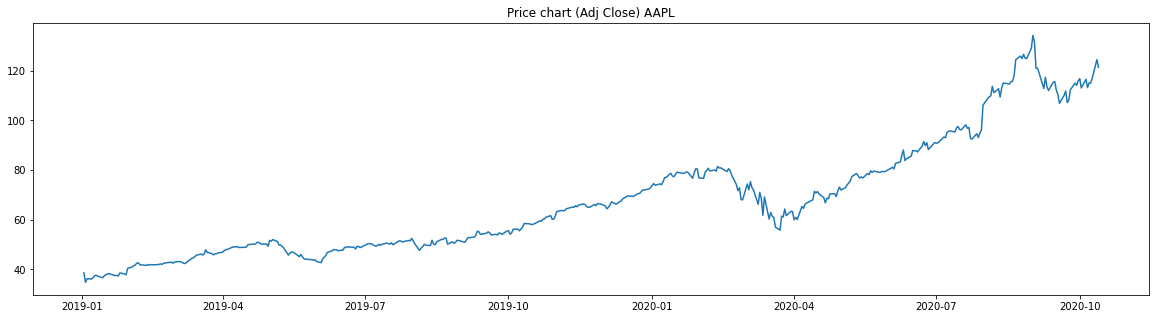

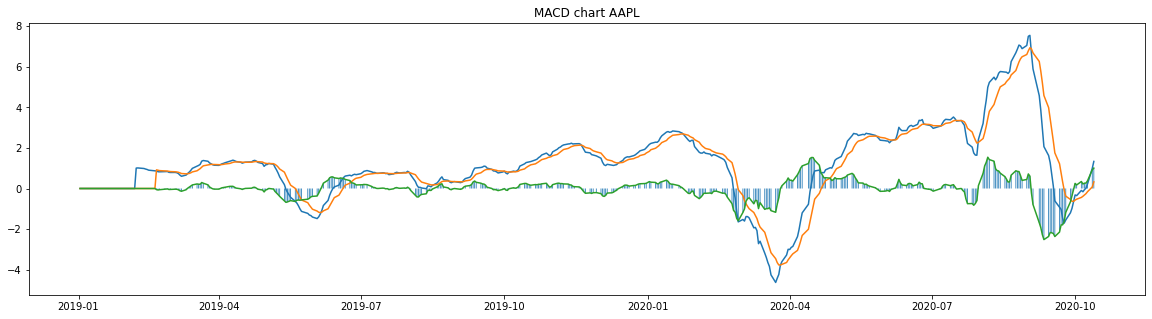

In [140]:
# plot price
plt.figure(figsize=(20,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(20,5))
plt.title('MACD chart ' + str(ticker))
plt.plot(df['Date'], df['MACD'].fillna(0))
plt.plot(df['Date'], df['MACDsig'].fillna(0))
plt.plot(df['Date'], df['MACDhist'].fillna(0))
plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)

plt.show()

In [141]:
#SIGNALS TAKEN FROM 
#https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience
#MODIFY THIS CELL

def buy_sell(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0,len(signal)):
        if signal['MACD'][i] > signal['MACDsig'][i]:   # first occurence of MACD crossing above signal oine
            Sell.append(np.nan)                        # so first flip above means buy
            if flag != 1:                              # after first occurence i record flip to ignore
                Buy.append(signal['Close'][i])         # from here onwards
                flag = 1
            else:
                Buy.append(np.nan)
        elif signal['MACD'][i] < signal['MACDsig'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Close'][i])
                flag = 0
            else:
                Sell.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return (Buy, Sell)            


# create buy and sell column
a = buy_sell(df)
df['Buy_Signal_Price'] = a[0]
df['Sell_Signal_Price'] = a[1]


In [142]:
df

,Date,High,Low,Open,Close,Volume,Adj Close,MACD,MACDsig,MACDhist,Buy_Signal_Price,Sell_Signal_Price
0,2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.629097,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.781353,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,36.266144,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,36.185429,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,37.955002,37.130001,37.389999,37.687500,164101200.0,36.875229,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
445,2020-10-07,115.550003,114.129997,114.620003,115.080002,96849000.0,115.080002,-0.055348,-0.318113,0.262765,NaN,NaN
446,2020-10-08,116.400002,114.589996,116.250000,114.970001,83477200.0,114.970001,0.018125,-0.250865,0.268990,NaN,NaN
447,2020-10-09,117.000000,114.919998,115.279999,116.970001,100506900.0,116.970001,0.235027,-0.153687,0.388714,NaN,NaN
448,2020-10-12,125.180000,119.279999,120.059998,124.400002,239388800.0,124.400002,0.994992,0.076049,0.918943,NaN,NaN


In [143]:
#mine implementation
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['High'], label='High', alpha=0.1)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.1)
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    #plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    #plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    #plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    #plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    #plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    #plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy_Signal_Price'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell_Signal_Price'], label='Sell', marker='v')

    plt.legend()

    plt.show()
    
    
    plt.figure(figsize=(20,5))
    plt.title('MACD chart ' + str(ticker))
    plt.plot(df['Date'], df['MACD'].fillna(0))
    plt.plot(df['Date'], df['MACDsig'].fillna(0))
    plt.plot(df['Date'], df['MACDhist'].fillna(0))
    plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)
    

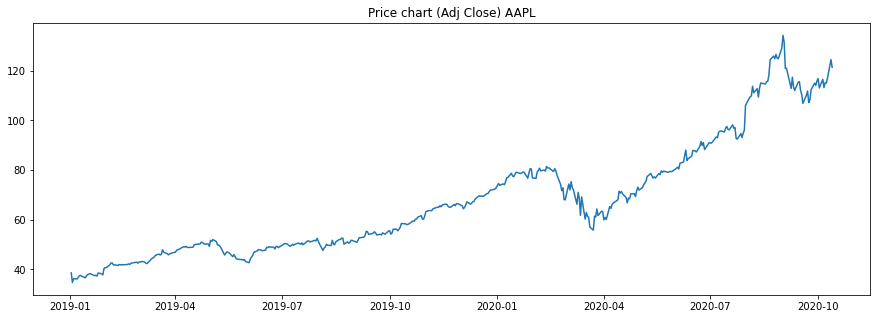

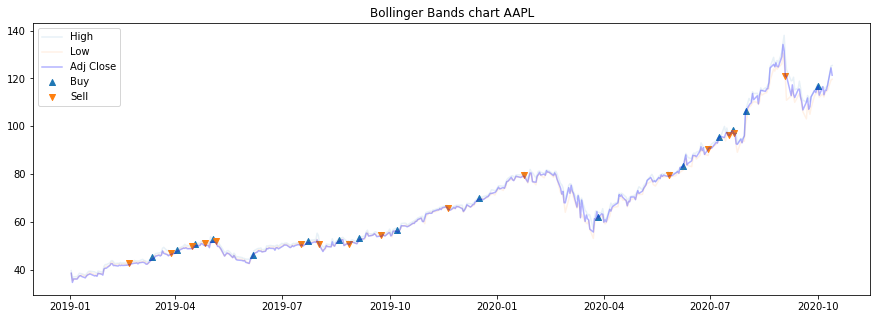

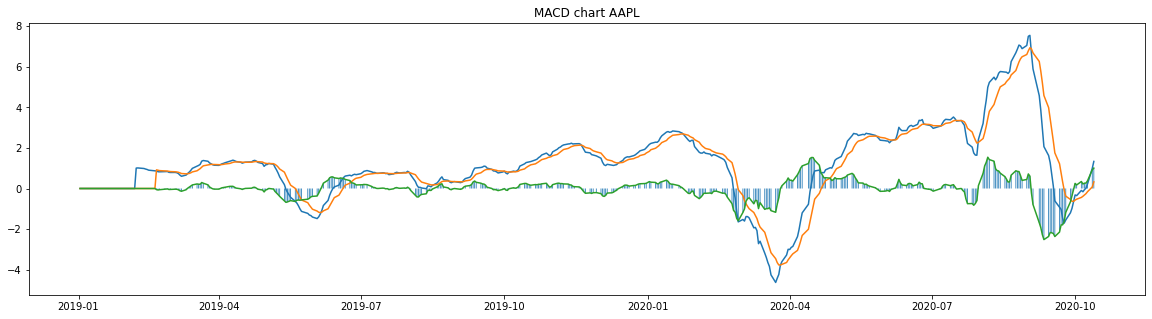

In [144]:
plot_signals(df, ticker)

#### Sources:
https://github.com/Crypto-toolbox/pandas-technical-indicators  <BR>
https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code  <BR>
https://www.investopedia.com/terms/m/macd.asp  <BR>    
https://www.youtube.com/watch?v=qyU9IM3M_Kw&ab_channel=EXFINSISExpertFinancialAnalysis   <BR> 
https://www.youtube.com/watch?v=E3KP1WyLITY&ab_channel=Trading212    <BR>
https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience